In [20]:
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import cluster
from sklearn import model_selection
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics

import optuna

from parsing import Downloader
from Curves import Curve

In [2]:
# Fix seed
random_state = 29

## Data load

In [3]:
colorsData = pd.read_csv('./data/hairColorsTrainData.csv', index_col=0)

colorsData

,brown-haired,light brown,blond,red hair,black
woman0photo0,0.038206,0.063123,0.870432,NaN,0.028239
woman0photo1,0.124685,0.254408,0.578086,NaN,0.042821
woman0photo2,NaN,NaN,NaN,NaN,NaN
woman0photo3,0.198309,0.424577,0.176203,0.169051,0.031860
woman0photo5,0.346715,0.405109,0.160584,0.003650,0.083942
...,...,...,...,...,...
woman1003photo2,0.308271,0.303258,0.185464,0.045113,0.157895
woman1003photo4,0.253395,0.335597,0.318084,0.002502,0.090422
woman1003photo5,0.071163,0.262347,0.656222,NaN,0.010267
woman1003photo6,0.409321,0.311061,0.207748,0.013476,0.058394


In [4]:
# Read json data
womanPhotos = pd.read_json(r'data\tinderData.json')
    
womans = dict() # Dict with urls for woman photos

for womanNumber, woman in enumerate(womanPhotos['photos']):
    for photoNumber, variable in enumerate(woman): # variable - Dictionary with photoraphy parameters (photos are available in various resolutions)
        womans['woman' + str(womanNumber) + 'photo' + str(photoNumber)] = variable['photo'][1]['url']

# Series with urls and woman idxs
womans = pd.Series(womans, name='Url')

womans.head()

woman0photo0    https://images-ssl.gotinder.com/u/r6pNUrsBA65M...
woman0photo1    https://images-ssl.gotinder.com/u/7dFzhcW6j1Rp...
woman0photo2    https://images-ssl.gotinder.com/u/q3yVNSYScQ7B...
woman0photo3    https://images-ssl.gotinder.com/u/1SrCG2faQWrm...
woman0photo4    https://images-ssl.gotinder.com/u/8NpvdxgDi61h...
Name: Url, dtype: object

## Data cleaning

In [5]:
colorsData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2106 entries, woman0photo0 to woman1003photo7
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brown-haired  1876 non-null   float64
 1   light brown   1870 non-null   float64
 2   blond         1842 non-null   float64
 3   red hair      1168 non-null   float64
 4   black         1879 non-null   float64
dtypes: float64(5)
memory usage: 98.7+ KB


In [6]:
colorsDf = colorsData.copy(deep=True)

# Delete gaps
n = colorsDf.shape[1]
colorsDf = colorsDf.dropna(thresh=n-3, axis=0)

# The remaining gaps are considered 
# to be the absence of pixels of this color
colorsDf = colorsDf.fillna(0).astype('float32')

# Duplicates
colorsDf = colorsDf.drop_duplicates()


colorsDf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1618 entries, woman0photo0 to woman1003photo7
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brown-haired  1618 non-null   float32
 1   light brown   1618 non-null   float32
 2   blond         1618 non-null   float32
 3   red hair      1618 non-null   float32
 4   black         1618 non-null   float32
dtypes: float32(5)
memory usage: 44.2+ KB


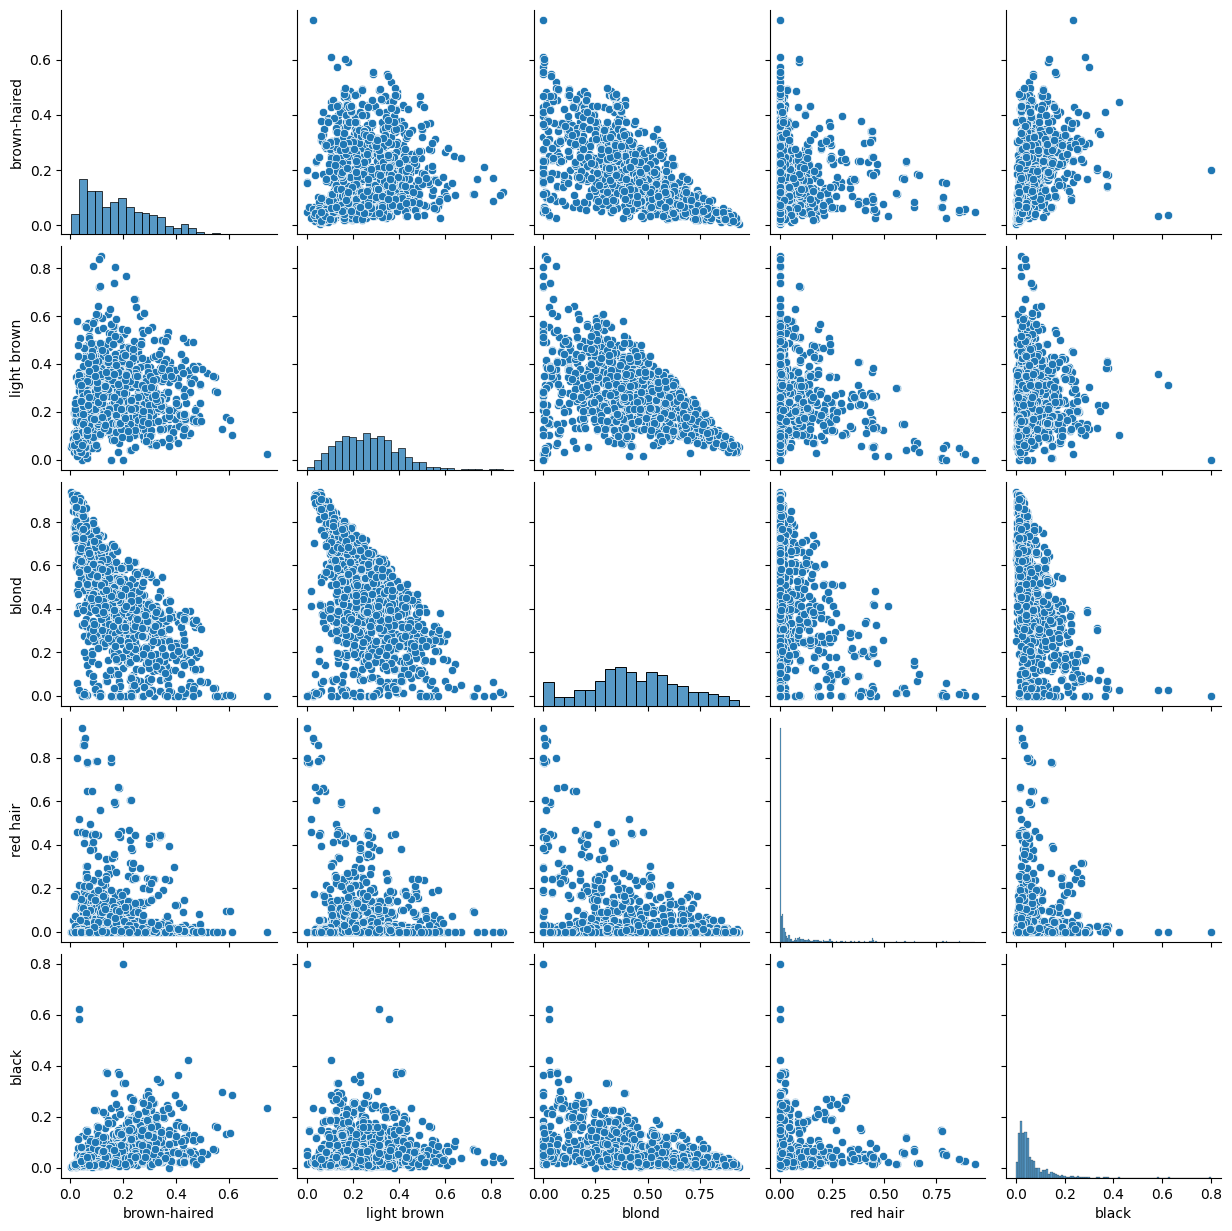

In [7]:
sns.pairplot(colorsDf)

In [8]:
# Remove outliers using the z deviation method
def outliers_z_score_mod(data: pd.DataFrame, feature :str,
                         log_scale :bool=False, left: int | float=3,
                         right: int | float=3) -> tuple:
    """The function determines outliers using the z deviation method

    Args:
        data (pd.DataFrame): Source dataset
        feature (str): Sign for cleaning
        log_scale (bool, optional): Feature logarithm. Defaults to False.
        left (int | float, optional): Left limit of normal values(relative to box width). Defaults to 3.
        right (int | float, optional): Right limit of normal values(relative to box width). Defaults to 3.

    Returns:
        tuple: Outliers and Cleaned Dataset
    """
    
    if log_scale:
        x = np.log(data[feature] + 0.0001)
    else:
        x = data[feature]
        
    mu = np.mean(x)
    sigma = np.std(x)
    
    upper_bound = mu + right*sigma
    lower_bound = mu - left*sigma
    
    outliers = data[(x<lower_bound) | (x>upper_bound)]
    cleaned = data[(x>lower_bound) & (x<upper_bound)]
    
    return outliers, cleaned


# Remove outliers for each feature, taking into account the distribution
for col in colorsDf.columns:
    if col in ['brown-haired', 'black']:
        outliers, colorsDf = outliers_z_score_mod(colorsDf, col, log_scale=True)
    elif col == 'red hair':
        continue
    else:
        outliers, colorsDf = outliers_z_score_mod(colorsDf, col)
        
    print(f'Number of outliers in a trait "{col}": {outliers.shape[0]}')
    
print(f'Resulting Number of Records(train sample): {colorsDf.shape[0]}')

Number of outliers in a trait "brown-haired": 4
Number of outliers in a trait "light brown": 11
Number of outliers in a trait "blond": 0
Number of outliers in a trait "black": 5
Resulting Number of Records(train sample): 1598


## Data research and markup

In [9]:
colorsDf.describe()

,brown-haired,light brown,blond,red hair,black
count,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000
mean,0.181492,0.261049,0.440549,0.053961,0.062948
std,0.120355,0.123428,0.217840,0.122681,0.060917
min,0.014213,0.000000,0.000000,0.000000,0.003432
25%,0.080138,0.162376,0.302010,0.000000,0.023816
50%,0.163164,0.255120,0.424865,0.003680,0.042850
75%,0.261944,0.345766,0.589804,0.036547,0.076590
max,0.744186,0.642523,0.930795,0.937500,0.583846


In [10]:
# Clasterization and markup
km = cluster.SpectralClustering(n_clusters=5, random_state=random_state, n_jobs=-1)
km.fit(colorsDf)

colorsDf['cluster'] = km.labels_

colorsDf['cluster'].value_counts()

cluster
0    632
2    450
1    282
4    158
3     76
Name: count, dtype: int64

In [11]:
# Uploading photos to refine the markup

#for clustNum in range(5):
#    for woman in colorsDf[colorsDf['cluster'] == clustNum].index:
#        Downloader(url=womans[woman]) \
#            .photoDownload(name=woman, path='imgs/' + str(clustNum) + '/')

In [12]:
clusterStat = colorsDf.groupby('cluster').median()

clusterStat

,brown-haired,light brown,blond,red hair,black
cluster,,,,,
0,0.117291,0.339887,0.442676,0.003880,0.035002
1,0.049172,0.122111,0.766522,0.000735,0.026253
2,0.274019,0.206130,0.383499,0.003564,0.062666
3,0.165713,0.144463,0.033742,0.445559,0.042449
4,0.328356,0.366549,0.116903,0.009547,0.147885


In [13]:
# Dict to interpret. classes
colorClasses = {
    0: 'light brown',
    1: 'blond',
    2: 'brown-haired',
    3: 'red hair',
    4: 'black'
}

[Text(0.5, 1.0, 'Distribution hair colors in data')]

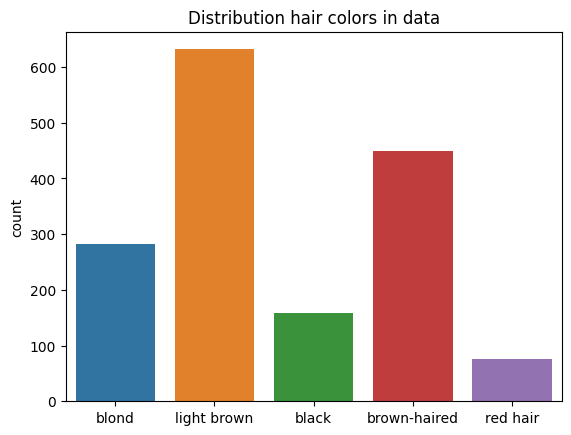

In [14]:
sns.countplot(
    data=colorsDf['cluster'].replace(colorClasses),
    x=colorsDf['cluster'].replace(colorClasses).values
).set(title='Distribution hair colors in data')

## Data preparation


In [15]:
# Highlight the target
X = colorsDf.drop('cluster', axis=1)
y = colorsDf['cluster']

# Split samples
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=random_state
)

## Modeling

### Default params best algorithm

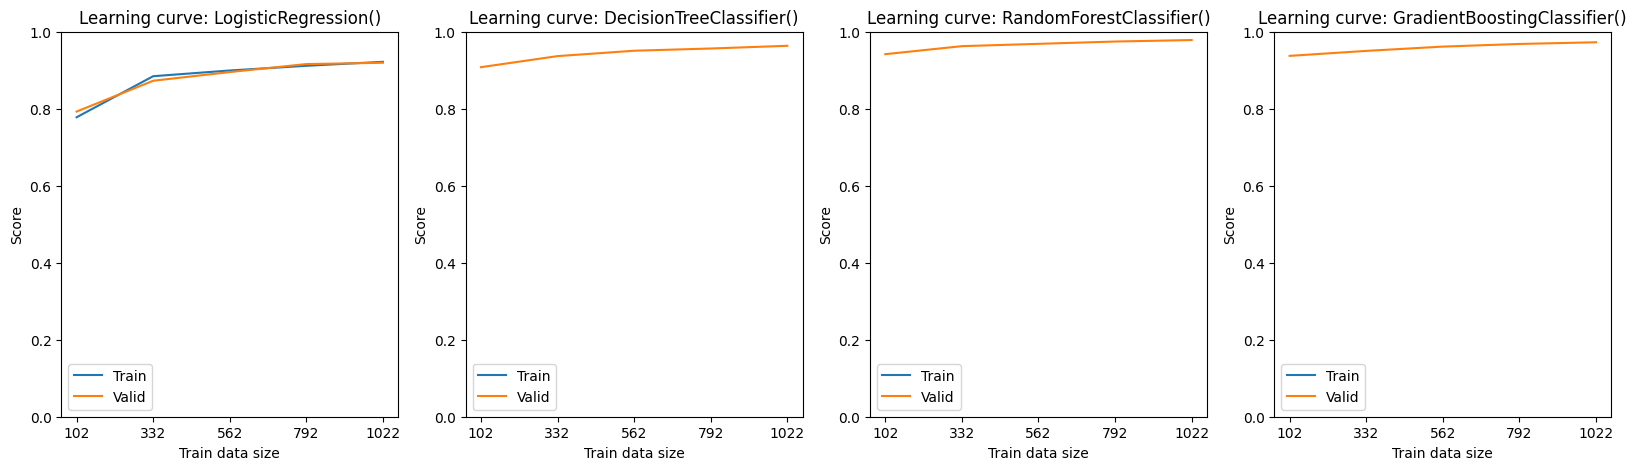

In [16]:
models = [
    linear_model.LogisticRegression(
        random_state=random_state,
        class_weight='balanced'
    ),
    tree.DecisionTreeClassifier(
        random_state=random_state,
        class_weight='balanced'
    ),
    ensemble.RandomForestClassifier(
        random_state=random_state,
        class_weight='balanced'
    ),
    ensemble.GradientBoostingClassifier(
        random_state=random_state
    )
]

# Cross-validator
rskf = model_selection.RepeatedStratifiedKFold(n_repeats=3, n_splits=5)

# Learning curves
fig, axes = plt.subplots(1, len(models), figsize=(20, 5))

for i, model in enumerate(models):
    Curve.plot_learning_curve(
        Curve,
        model=model,
        X=X_train,
        y=y_train,
        cv=rskf,
        scoring='f1_weighted',
        title=model.__class__.__name__ + '()',
        ax=axes[i]
    )

### Tuning hyperparametres for RandomForestClassifier

In [17]:
# Optuna

def optuna_rf(trial: optuna.trial.Trial) -> float:
    """Function fit RandomForestClassifier with set params
    and return f1-score on cross-validation

    Args:
        trial (optuna.trial.Trial): A trial is a process of evaluating an objective function

    Returns:
        float: f1-score
    """
    # Params
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=10)
    max_depth = trial.suggest_int('max_depth', 3, 40)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 15)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        class_weight=class_weight,
        random_state=random_state
    )
    
    score = model_selection.cross_val_score(
        model,
        X_train,
        y_train,
        cv=rskf,
        scoring='f1_weighted',
        n_jobs=-1
    )
    
    return score.mean()


# Tuning
study_rf = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
study_rf.optimize(optuna_rf, n_trials=50, n_jobs=-1)

print('Optuna best params on RandomForestClassifier:', study_rf.best_params)

[I 2023-07-24 18:45:50,270] A new study created in memory with name: RandomForestClassifier
[I 2023-07-24 18:46:00,162] Trial 4 finished with value: 0.9605538384095031 and parameters: {'n_estimators': 320, 'max_depth': 9, 'min_samples_leaf': 13, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 4 with value: 0.9605538384095031.
[I 2023-07-24 18:46:01,090] Trial 0 finished with value: 0.9558707519188923 and parameters: {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 10, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 4 with value: 0.9605538384095031.
[I 2023-07-24 18:46:01,396] Trial 10 finished with value: 0.9643406186346531 and parameters: {'n_estimators': 190, 'max_depth': 35, 'min_samples_leaf': 5, 'criterion': 'log_loss', 'class_weight': 'balanced'}. Best is trial 10 with value: 0.9643406186346531.
[I 2023-07-24 18:46:03,900] Trial 11 finished with value: 0.9630498597782641 and parameters: {'n_estimators': 60, 'max_depth': 37, 'min_

Optuna best params on RandomForestClassifier: {'n_estimators': 230, 'max_depth': 15, 'min_samples_leaf': 3, 'criterion': 'log_loss', 'class_weight': 'balanced'}


In [18]:
# Modeling on best params

rf_optuna = ensemble.RandomForestClassifier(**study_rf.best_params, random_state=random_state)

rf_optuna.fit(X_train, y_train)

print('F1-weighted score:', \
    metrics.f1_score(
        y_test,
        rf_optuna.predict(X_test),
        average='weighted'
        ).round(4)
)

F1-weighted score: 0.957


In [19]:
print(metrics.classification_report(y_test, rf_optuna.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       127
           1       0.98      0.96      0.97        56
           2       0.95      0.96      0.95        90
           3       1.00      1.00      1.00        15
           4       0.82      1.00      0.90        32

    accuracy                           0.96       320
   macro avg       0.95      0.97      0.96       320
weighted avg       0.96      0.96      0.96       320



## Model saving

In [21]:
with open('data/trained_model-0.1.0.pkl', 'wb') as f:
    pickle.dump(rf_optuna, f)